## Exploration of quantile regression (QR) via neural networks

Credits: https://github.com/maxmarketit/Auto-PyTorch

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

### Generate noisy sin data

In [76]:
N = 10000
np.random.seed(42)

x = np.random.normal(0, 1, (N,))

## noisy sine
y = np.sin(x * 3) + np.random.normal(scale=0.5, size=len(x))

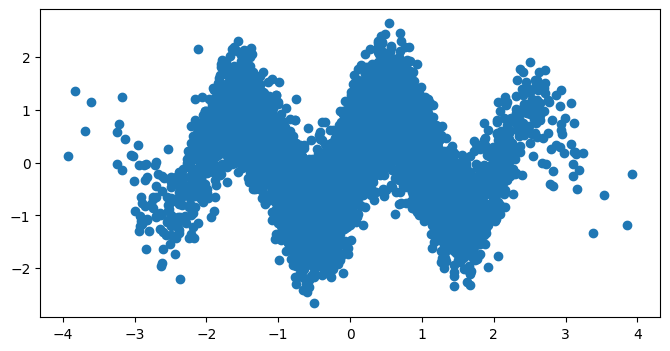

In [78]:
plt.figure(figsize=(8, 4))
plt.scatter(x, y)

# Model and Pinball loss

In [85]:
class QRModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 3),
        )

    def forward(self, x):
        return self.net(x)

In [244]:
class PinballLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.pred = None
        self.targes = None
        self.quantiles = quantiles

    def forward(self, pred, target):

        assert not target.requires_grad
        assert pred.size(0) == target.size(0)

        error = target - pred
        upper = self.quantiles * error
        lower = (self.quantiles - 1) * error

        losses = torch.max(lower, upper)
        loss = torch.mean(
            torch.sum(losses, dim=-1)
        )  ## sum across quantiles per instance, then batch mean
        return loss

# sanity check on pinball loss

In [245]:
quantiles = torch.tensor([0.2, 0.8])
criterion = PinballLoss(quantiles)

In [246]:
preds = torch.tensor([[5.2, 10.5], [1.5, 3.4], [1.2, 3.2]])
target = torch.tensor([[5, 9.8], [1, 3.36], [2, 3.1]])
assert torch.isclose(criterion(preds, target), torch.tensor([0.296]))
### explanation: for x1 and τ=0.2, target-pred < 0, so we take (τ-1)*(target-pred) = -0.8*-0.2 = 0.16,
## for x1 τ=0.8, -0.2*-0.7 = 0.14,
# ....for x3, τ=0.2, target-pred > 0, so we take τ*(target-pred) = 0.2*0.8 = 0.16
## we get 0.16 0.14
##        0.4  0.008
##        0.16 0.02
## we sum across each instance then take the batch mean = [0.3, 0.408, 0.18] = 0.888, mean = 0.296

# back to the real deal

In [343]:
train_x = torch.from_numpy(x.reshape(-1, 1)).float()
train_y = torch.from_numpy(y.reshape(-1, 1)).float()

In [344]:
train_loader = torch.utils.data.DataLoader(
    torch.cat([train_x, train_y], dim=-1), batch_size=16, shuffle=True
)

In [345]:
model = QRModel()
model.train()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

quantiles = torch.tensor([0.05, 0.5, 0.95])
criterion = PinballLoss(quantiles)

In [357]:
train_x.shape, train_y.shape, out.shape

(torch.Size([16, 1]), torch.Size([16, 1]), torch.Size([16, 3]))

In [346]:
for epoch in range(5):
    for step, batch in enumerate(train_loader):
        train_x, train_y = batch[:, 0].unsqueeze(-1), batch[:, 1].unsqueeze(-1)
        optimizer.zero_grad()
        out = model(train_x)
        loss = criterion(out, train_y)
        loss.backward()
        optimizer.step()

        if step % 250 == 0:
            print(f"Epoch {epoch+1} | Loss: {loss.item()}")

Epoch 1 | Loss: 1.2151767015457153
Epoch 1 | Loss: 0.4580264091491699
Epoch 1 | Loss: 0.30673304200172424
Epoch 2 | Loss: 0.29393893480300903
Epoch 2 | Loss: 0.34148287773132324
Epoch 2 | Loss: 0.3728770613670349
Epoch 3 | Loss: 0.3805145025253296
Epoch 3 | Loss: 0.351211279630661
Epoch 3 | Loss: 0.2629702091217041
Epoch 4 | Loss: 0.248721644282341
Epoch 4 | Loss: 0.3046843111515045
Epoch 4 | Loss: 0.24929189682006836
Epoch 5 | Loss: 0.3306560814380646
Epoch 5 | Loss: 0.3858877718448639
Epoch 5 | Loss: 0.2511623501777649


In [347]:
x_test = torch.arange(-3, 3, 0.1).unsqueeze(-1)
model.eval()
with torch.no_grad():
    y_test = model(x_test)

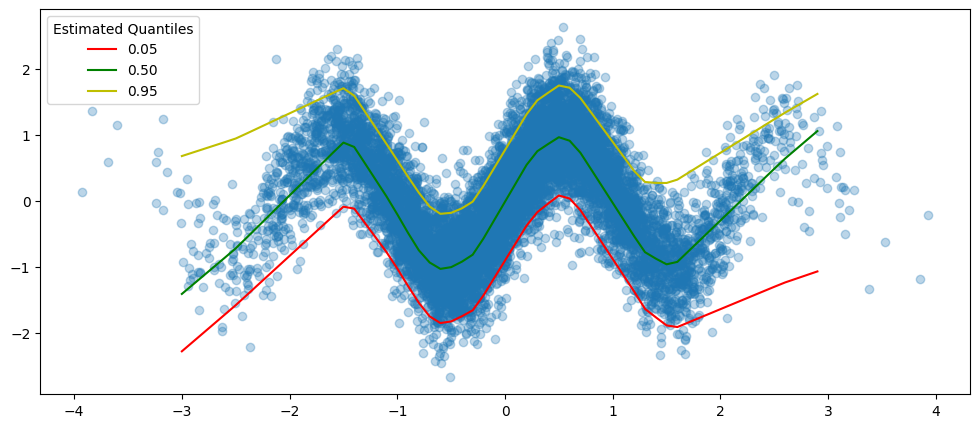

In [364]:
plt.figure(figsize=(12, 5))
plt.scatter(x, y, alpha=0.3)
plt.plot(x_test, y_test[:, 0], color="r", label="0.05")
plt.plot(x_test, y_test[:, 1], color="g", label="0.50")
plt.plot(x_test, y_test[:, 2], color="y", label="0.95")
plt.legend(title="Estimated Quantiles")

# TODO shortly: a much much more complex model and setup?

### In-progress: *MCNN_QR*

#### Goal: Adapt MCNN density map prediction to predict three density maps

Idea: change self.fuse from nn.Conv2d(30, 1) to (30, 3).  
Then write a wrapper pinball loss that uses MSELoss (not literally, but mean-squared error) as the `error` variable in its computation.  
use this to try and train MCNN_QR to predict 0.05, 0.5, 0.95 density maps...